# Explicit WFA Inversion (Refactored)

This notebook demonstrates the usage of the refactored `neural_wfa` package for EXPLICIT (pixel-by-pixel) inversion.

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os, sys

# Ensure src is in path if running locally
sys.path.append("src")
sys.path.append("../src")

from neural_wfa import Observation, WFAProblem
from neural_wfa.physics import LineInfo
from neural_wfa.optimization import PixelSolver
from neural_wfa.analysis.uncertainty import estimate_uncertainties_diagonal
from neural_wfa import MagneticField
from neural_wfa.utils import set_params
set_params()

## 1. Load Data

In [14]:
# Handle data path (check example/ or ../example)
datadir = "example/plage_sst/"
if not os.path.exists(datadir):
    datadir = "plage_sst/"

img = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_dat.fits", "readonly")[0].data,
    dtype="float32",
)
xl = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_wav.fits", "readonly")[0].data,
    dtype="float32",
)

print("Data shape:", img.shape)
ny, nx, ns, nw = img.shape

Data shape: (200, 178, 4, 13)


## 2. Setup Problem

In [15]:
# Force CPU for explicit examples to ensure stability
device = torch.device("cpu") 
print("Using device:", device)

# Observation
obs = Observation(img, xl, mask=[5, 6, 7], device=str(device))

# Line Parameters
lin = LineInfo(5173)

# WFA Physics Engine
# Pass mask for correct Initial Guess computation
problem = WFAProblem(obs, lin, weights=[10, 10, 10], mask=torch.tensor([5, 6, 7]), device=device)


Using device: cpu


## 3. Pixel Solver

In [16]:
# Initialize Solver
solver = PixelSolver(problem, nt=1, device=device)

# Initialize Parameters using Weak Field Approximation (Much faster convergence)
solver.initialize_parameters(method='weak_field')


Plotting Initial Guess (WFA)...


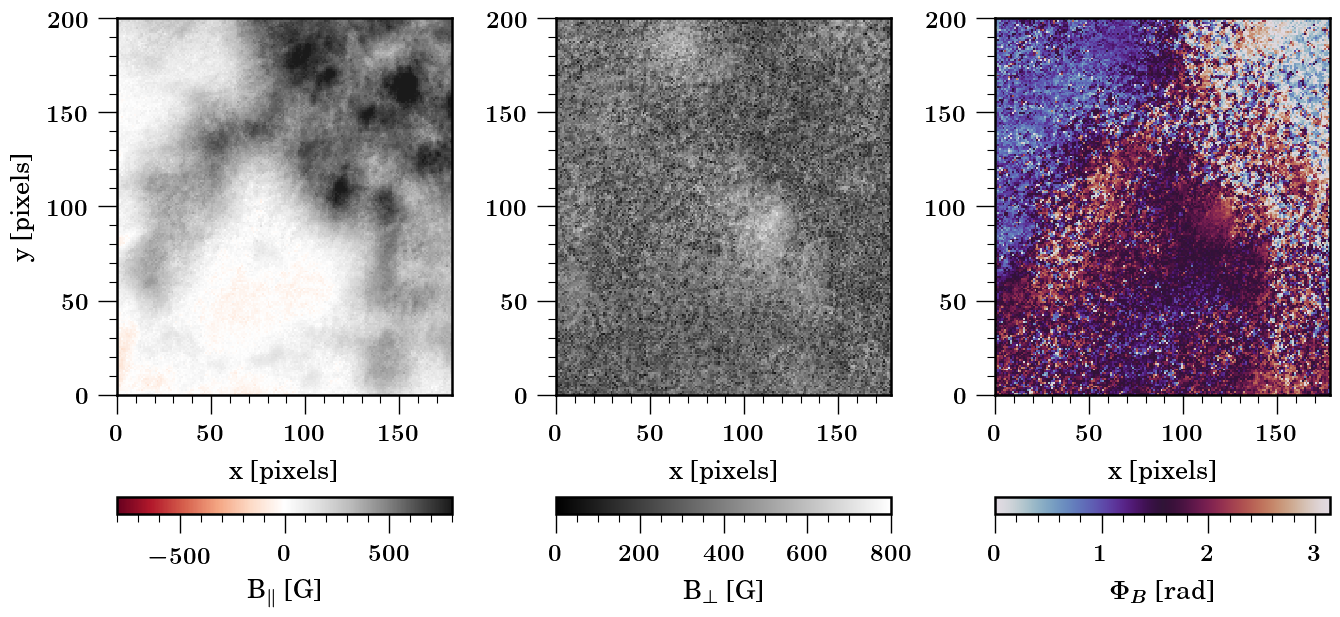

In [17]:
print("Plotting Initial Guess (WFA)...")
initial_field = solver.get_field()
blos_0 = initial_field.blos.detach().cpu().numpy().reshape(ny, nx)
bq_0 = initial_field.b_q.detach().cpu().numpy().reshape(ny, nx)
bu_0 = initial_field.b_u.detach().cpu().numpy().reshape(ny, nx)
btrans_0 = np.sqrt(np.sqrt(bq_0**2 + bu_0**2))
azi_0 = 0.5 * np.arctan2(bu_0, bq_0)
azi_0[azi_0 < 0] += np.pi

# Legacy Style Plot
fs = (9*1.5, 4.5*1.5)
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=fs)

save_name = 'ref_initial_guess.png'
im0 = ax[0].imshow(blos_0, vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(btrans_0, vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(azi_0, vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
plt.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
plt.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
plt.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)

for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
ax[0].set_ylabel('y [pixels]')
plt.tight_layout()
if 'save_name' in locals():
    plt.savefig(save_name, dpi=300)
plt.show()

In [ ]:
print("Starting Inversion...")
solver.solve(
    n_iterations=200,
    lr=1e-2, # Explicit optimization usually allows higher LR than Neural
    reguV=1e-4, 
    reguQU=1e-2,
    verbose=True
)


Starting Inversion...


100%|██████████| 200/200 [00:01<00:00, 107.19it/s, total=0.262, chi2=0.258, spatial=0.00369, temporal=0]


## 4. Analysis & Visualization

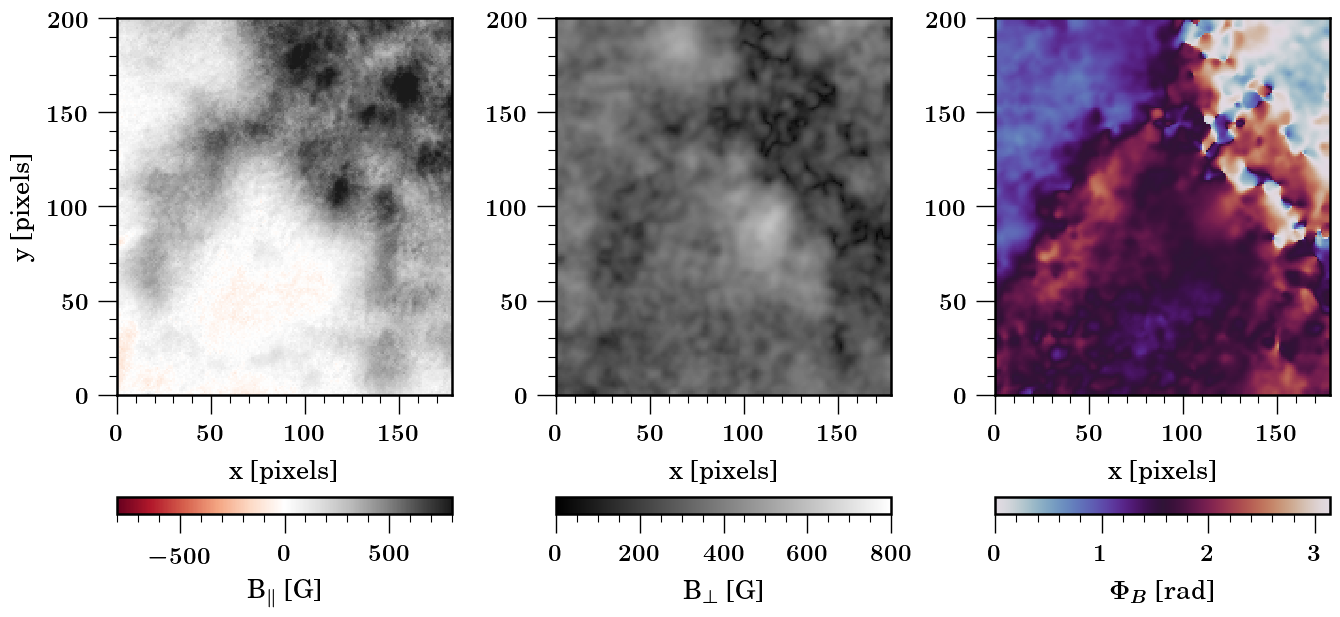

In [19]:

final_field = solver.get_field()

# 1. Magnetic Field Maps
blos_map = final_field.blos.detach().cpu().numpy().reshape(ny, nx)
bq_map = final_field.b_q.detach().cpu().numpy().reshape(ny, nx)
bu_map = final_field.b_u.detach().cpu().numpy().reshape(ny, nx)
btrans_map = np.sqrt(np.sqrt(bq_map**2 + bu_map**2))
azi_map = 0.5 * np.arctan2(bu_map, bq_map)
azi_map[azi_map < 0] += np.pi

# Legacy Style Plot
fs = (9*1.5, 4.5*1.5)
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=fs)

save_name = 'ref_results.png'
im0 = ax[0].imshow(blos_map, vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(btrans_map, vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(azi_map, vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
plt.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
plt.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
plt.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)

for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
ax[0].set_ylabel('y [pixels]')
plt.tight_layout()
if 'save_name' in locals():
    plt.savefig(save_name, dpi=300)
plt.show()


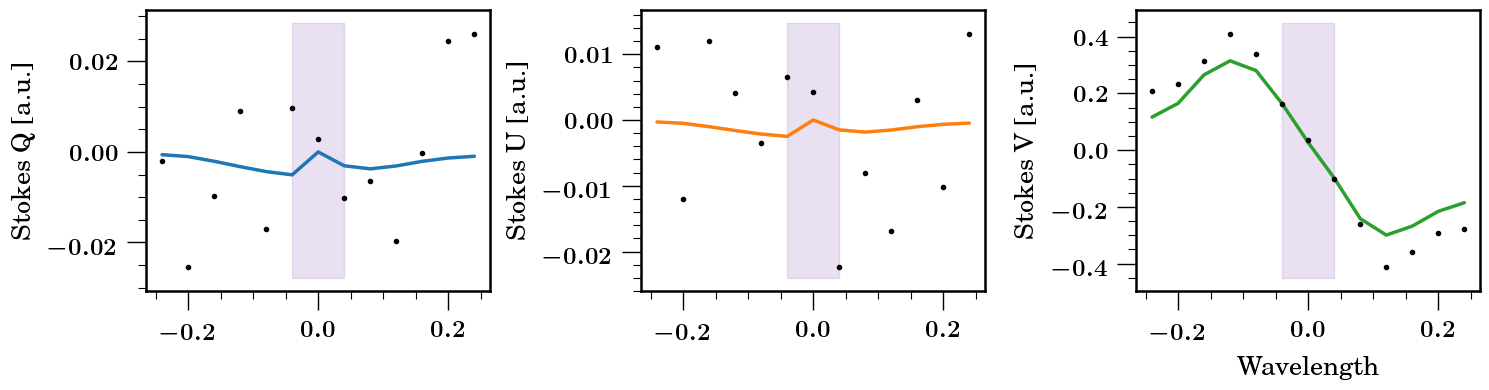

In [20]:
# 2. Profile Fitting Check
# Select a pixel with strong signal (Matching Legacy: 150, 150)
px, py = 150, 150 # Legacy uses (150, 150)
x, y = 150, 150 
idx = py * nx + px
indices = torch.tensor([idx], device=device)

# Compute Model Profiles
field_sub = MagneticField(
    final_field.blos[indices],
    torch.stack([final_field.b_q[indices], final_field.b_u[indices]], dim=-1)
)

stokesQ, stokesU, stokesV = problem.compute_forward_model(field_sub, indices=indices)

obs_Q = obs.stokes_Q[indices].detach().cpu().numpy().flatten()
obs_U = obs.stokes_U[indices].detach().cpu().numpy().flatten()
obs_V = obs.stokes_V[indices].detach().cpu().numpy().flatten()
mod_Q = stokesQ.detach().cpu().numpy().flatten()
mod_U = stokesU.detach().cpu().numpy().flatten()
mod_V = stokesV.detach().cpu().numpy().flatten()
wav = obs.wavelengths.detach().cpu().numpy()

# Legacy Style Plot
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10*1.5,4))
ax = ax.flatten()

# Q
ax[0].plot(wav, mod_Q, label='Stokes Q', color='C0')
ax[0].plot(wav, obs_Q, 'k.', label='Stokes Q')
ax[0].set_ylabel('Stokes Q [a.u.]')

# U
ax[1].plot(wav, mod_U, label='Stokes U', color='C1')
ax[1].plot(wav, obs_U, 'k.', label='Stokes U')
ax[1].set_ylabel('Stokes U [a.u.]')

# V
ax[2].plot(wav, mod_V, label='Stokes V', color='C2')
ax[2].plot(wav, obs_V, 'k.', label='Stokes V')
ax[2].set_xlabel(r"Wavelength")
ax[2].set_ylabel('Stokes V [a.u.]')

# Vertical band for mask (Legacy style)
mask_indices = [5, 6, 7] # As defined in problem setup
# Assuming wav is sorted? Legacy uses mymodel.wl[mask_indexs]
w_min = wav[mask_indices[0]]
w_max = wav[mask_indices[-1]]

for ii in range(3):
    # Find min/max for scaling band? Legacy determines from data.
    # Using ax limits instead or manual.
    ylim = ax[ii].get_ylim()
    ax[ii].fill_betweenx(
        ylim,
        w_min,
        w_max,
        color='C4',
        alpha=0.2,
        label='Mask used for the estimation',
    )
save_name = 'ref_pixel_profiles.png'
plt.tight_layout()
if 'save_name' in locals():
    plt.savefig(save_name, dpi=300)
plt.show()

Total Loss: 0.10
Computing Chi2 Maps...
Estimated sigma: 0.020288762


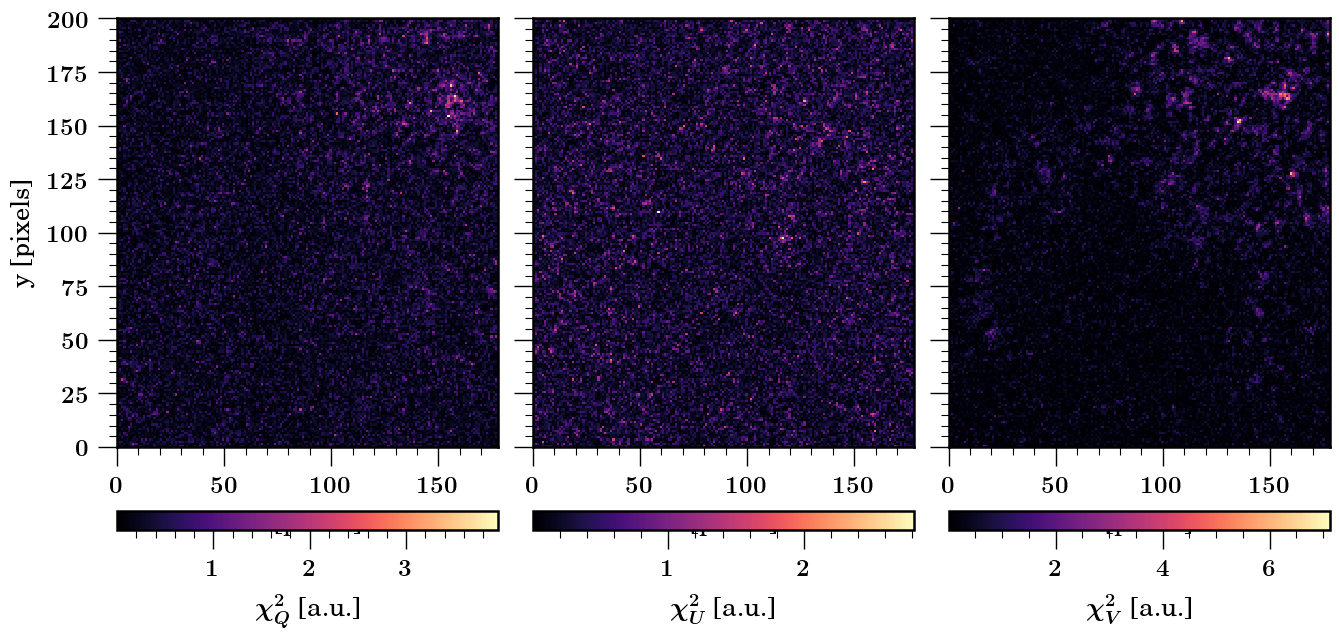

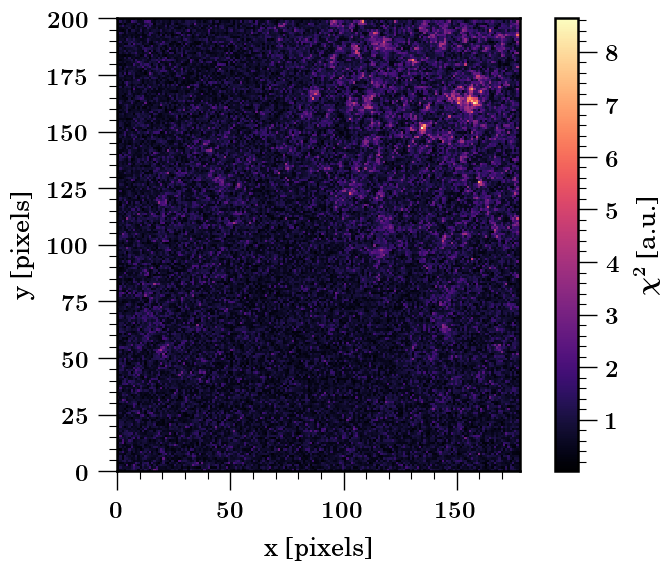

In [21]:
# 3. Loss (Chi2) Map
loss_val = problem.compute_loss(final_field).item()
print(f"Total Loss: {loss_val:.2f}")

# 3b. Chi2 Spatial Maps
print("Computing Chi2 Maps...")
stokesQ, stokesU, stokesV = problem.compute_forward_model(final_field)

obs_Q = obs.stokes_Q.detach().cpu().numpy().reshape(ny, nx, nw)
obs_U = obs.stokes_U.detach().cpu().numpy().reshape(ny, nx, nw)
obs_V = obs.stokes_V.detach().cpu().numpy().reshape(ny, nx, nw)

mod_Q = stokesQ.detach().cpu().numpy().reshape(ny, nx, nw)
mod_U = stokesU.detach().cpu().numpy().reshape(ny, nx, nw)
mod_V = stokesV.detach().cpu().numpy().reshape(ny, nx, nw)

diff_Q = mod_Q - obs_Q
sigma_est = np.std(diff_Q)
print(f"Estimated sigma: {sigma_est:.9f}")

mask_indices = [5, 6, 7] # As defined in problem setup
# Legacy slices with `[..., mymodel.mask]`.
# `chi2_map_Q = np.mean( (stokesQ... - img...)[..., mask]**2, axis=2 ) / sigma^2`
chi2_Q = np.mean((mod_Q[..., mask_indices] - obs_Q[..., mask_indices])**2, axis=2) / (sigma_est**2)
chi2_U = np.mean((mod_U[..., mask_indices] - obs_U[..., mask_indices])**2, axis=2) / (sigma_est**2)
chi2_V = np.mean((mod_V[..., mask_indices] - obs_V[..., mask_indices])**2, axis=2) / (sigma_est**2)
chi2_total = chi2_Q + chi2_U + chi2_V

# Legacy Style Plot
fs = (9*1.5, 7)
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=fs, sharex=True, sharey=True)
ax = ax.flatten()

# Helper for compat since we don't have utils.add_colorbar
def add_cb(im, ax, label):
    plt.colorbar(im, ax=ax,  orientation='horizontal', label=label, pad=0.1)

save_name = 'ref_chi2_components.png'
im0 = ax[0].imshow(chi2_Q, cmap='magma', interpolation='nearest', extent=extent)
im1 = ax[1].imshow(chi2_U, cmap='magma', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(chi2_V, cmap='magma', interpolation='nearest', extent=extent)

names = [r'$\chi^2_Q$', r'$\chi^2_U$', r'$\chi^2_V$']
add_cb(im0, ax[0], names[0]+' [a.u.]')
add_cb(im1, ax[1], names[1]+' [a.u.]')
add_cb(im2, ax[2], names[2]+' [a.u.]')

for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
ax[0].set_ylabel('y [pixels]')
plt.tight_layout()
# if 'save_name' in locals():
#     plt.savefig(save_name, dpi=300)
plt.show()


# Total Chi2 Plot
plt.figure(figsize=(6*1.5,4*1.5))
im = plt.imshow(chi2_total, cmap='magma', interpolation='nearest', extent=extent)
plt.colorbar(im, label=r"$\chi^2$ [a.u.]")
plt.ylabel('y [pixels]')
plt.xlabel('x [pixels]')
save_name = 'ref_chi2_total.png'
# if 'save_name' in locals():
#     plt.savefig(save_name, dpi=300)
plt.show()


Estimating Uncertainties...


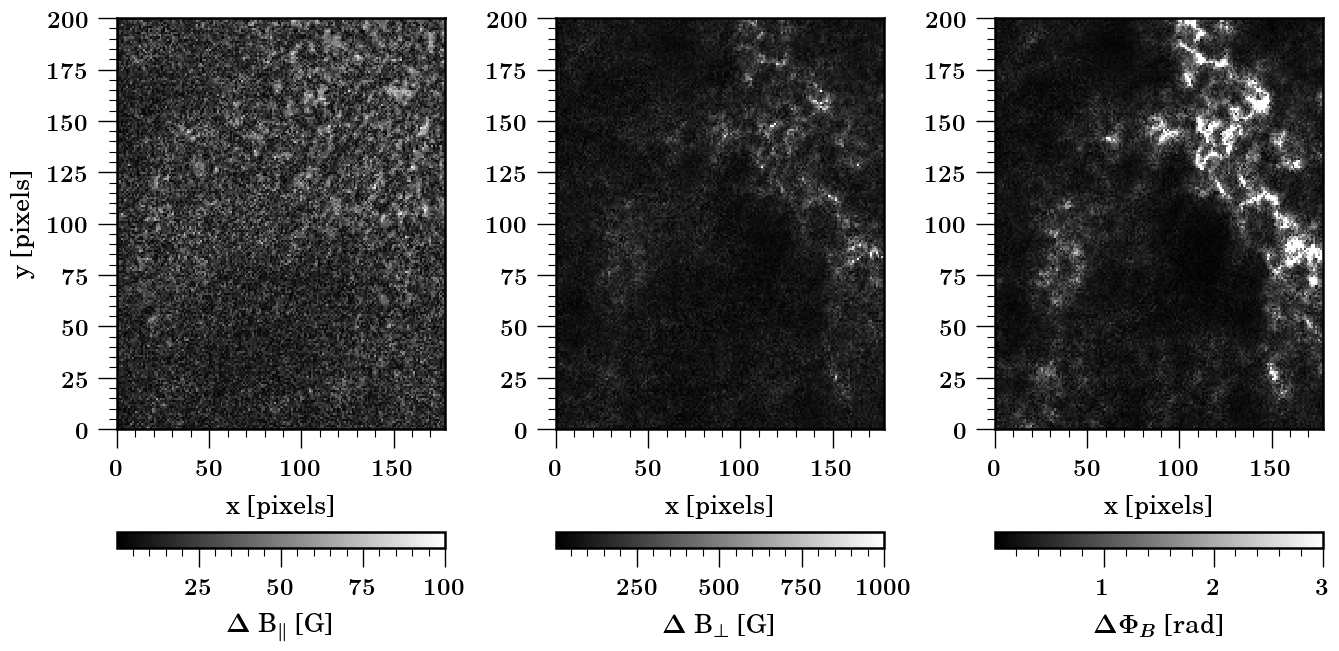

In [22]:

# 4. Uncertainty Estimation (Analytical)
print("Estimating Uncertainties...")
# Returns tuple: (sigma_blos, sigma_btrans, sigma_phi)
unc_blos, unc_btrans, unc_phi = estimate_uncertainties_diagonal(problem, final_field)

unc_blos = unc_blos.reshape(ny, nx)
unc_btrans = unc_btrans.reshape(ny, nx)
unc_phi = unc_phi.reshape(ny, nx)

# Legacy Style Plot
fs = (9*1.5, 4.5*1.5)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=fs)

# Scales from legacy: vmax=1e2, 1e3, 3
save_name = 'ref_uncertainties.png'
im0 = ax[0].imshow(unc_blos, extent=extent, aspect='auto', cmap='gray', vmax=1e2)
im1 = ax[1].imshow(unc_btrans, extent=extent, aspect='auto', cmap='gray', vmax=1e3)
im2 = ax[2].imshow(unc_phi, extent=extent, aspect='auto', cmap='gray', vmax=3)

names = [r'$\Delta$ B$_\parallel$', r'$\Delta$ B$_\bot$', r'$\Delta \Phi_B$']
plt.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
plt.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
plt.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)

for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
ax[0].set_ylabel('y [pixels]')
plt.tight_layout()
# plt.savefig('ref_uncertainties.png', dpi=300)
plt.show()